# Description

To evaluate the effectiveness of our approach, we used 80 percent of the WRDS dataset that had been cleaned using the K-Fold approach as a train set. The remaining 20 percent of the dataset, which had not been cleaned and was immediately saved, was used as a test set. We utilized the sentence transformer, specifically the 'all-mpnet-base-v2' model, to embed the descriptions in the training set. We then fed this embedded set into the OneVsRestClassifier, which employed the Support Vector Classifier (SVC) model as an estimator, utilizing the default radial basis function (rbf) kernel and default number of iterations. The resulting model was then tested using the aforementioned test set, which was also embedded using the same sentence transformer.

Additionally, we conducted a comparison between our model and ChatGPT in classifying the company descriptions using the OpenAI API. It's important to note that ChatGPT had prior knowledge about the companies mentioned in the company descriptions (from their names), which could have introduced bias in its predictions.

In [ ]:
!pip install gdown

In [ ]:
!gdown '1GCqhUVAnlfwPg0RJCaTmpS2ANBbHcd76'

Downloading...
From: https://drive.google.com/uc?id=1GCqhUVAnlfwPg0RJCaTmpS2ANBbHcd76
To: /content/eighty_percent.csv
100% 4.96M/4.96M [00:00<00:00, 16.3MB/s]


In [ ]:
!gdown '1ZksALnbqS_1DXucvu4_tmmDEyt3Nyp8Y'

Downloading...
From: https://drive.google.com/uc?id=1ZksALnbqS_1DXucvu4_tmmDEyt3Nyp8Y
To: /content/twenty_percent.csv
100% 1.47M/1.47M [00:00<00:00, 56.3MB/s]


#Preprocessing the dataset

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("eighty_percent.csv")
data.head()

,Sector Name,Sector Index,Description
0,Financials,40,"1895 Bancorp of Wisconsin, Inc. operates as a ..."
1,Consumer Staples (Consumer Defensive),30,Pavichevich Brewing Company engages in beer pr...
2,Financials,40,"Ameritrans Capital Corporation, together with ..."
3,Consumer Discretionary (Consumer Cyclical),25,"The Village Green Bookstore, Inc. does not hav..."
4,Materials,15,"Trilogy Metals Inc., a base metals exploration..."


In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["Sector Index"] = encoder.fit_transform(data["Sector Index"])
data["Sector Index"].value_counts()

6     3903
5     3425
7     3345
3     2645
1     2640
0     2001
2     1823
4      846
8      457
9      440
10     191
Name: Sector Index, dtype: int64

In [ ]:
my_tags = list(gics_sector.values())
len(my_tags)

11

#Embedding the train set

In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=eea3f40a86c86d7f945f2fc17169bfc314aba035bff5c6c34332aaf24362e2dc
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X_train = model.encode(list(data["Description"]))

In [ ]:
Y_train = list(data["Sector Index"])

#Training the model

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC())

clf.fit(X_train, Y_train)

OneVsRestClassifier(estimator=SVC())

#Importing the test set

In [ ]:
test = pd.read_csv("twenty_percent.csv")
test.head()

,Sector Index,Description
0,255040,"Vibra Energia S.A. manufactures, processes, di..."
1,551020,"Minnesota Gas Company, formerly known as Cente..."
2,201010,Howmet Aerospace Inc. provides advanced engine...
3,151040,Kingsgate Chile NL engages in the exploration ...
4,253010,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
import math

temp = []
for item in list(test["Sector Index"]):
  temp.append(math.floor(item/10000))

test["Sector Index"] = temp

In [ ]:
test.head()

,Sector Index,Description
0,25,"Vibra Energia S.A. manufactures, processes, di..."
1,55,"Minnesota Gas Company, formerly known as Cente..."
2,20,Howmet Aerospace Inc. provides advanced engine...
3,15,Kingsgate Chile NL engages in the exploration ...
4,25,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
test["Sector Index"] = encoder.fit_transform(test["Sector Index"])
test["Sector Index"].value_counts()

7     1106
6     1058
3      960
5      878
1      793
2      769
0      545
4      260
8      236
9      150
10     113
Name: Sector Index, dtype: int64

#Embedding the test set

In [ ]:
X_test = model.encode(list(test["Description"]))

In [ ]:
Y_test = list(test["Sector Index"])

#Predictions on 20 percent test set

In [ ]:
y_pred = clf.predict(X_test)

#Results from predictions on 20 percent test set

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_test, y_pred, average='micro')))

[[475  29  19   5   3   1   5   7   0   1   0]
 [ 20 671  39  20  15  12   7   8   0   1   0]
 [ 16  48 428  75   9  25  28 127   1  12   0]
 [  8  23  65 670  36  15  30  86  22   4   1]
 [  1  10   3  26 184  30   3   2   0   1   0]
 [  2   6   6  10  10 817   8  16   1   1   1]
 [  5  11   7  23   2  20 965  18   0   2   5]
 [  7   8  45  51   3  21  22 934  11   4   0]
 [  0   1   5  59   1   8   2  73  86   0   1]
 [ 29   1  10   1   0   1   4   0   0 104   0]
 [  0   0   6  14   1   2  45   8   0   0  37]]
                                            precision    recall  f1-score   support

                                    Energy       0.84      0.87      0.86       545
                                 Materials       0.83      0.85      0.84       793
                               Industrials       0.68      0.56      0.61       769
Consumer Discretionary (Consumer Cyclical)       0.70      0.70      0.70       960
     Consumer Staples (Consumer Defensive)       0.70      0.

#OpenAI API

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.2 MB/s eta 0:00:00


In [ ]:
import openai

openai.api_key = 'INSERT-API-KEY-HERE'

In [ ]:
def generate_response(text):
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages = [
          {"role": "user", "content": "Your task is to classify a company based on its textual description using GICS. You will classify the sector of the company. Your response shall ONLY be the name of the sector. If you can't classify the company or there isn't enough information, then the response will only be 'None'. The format of the response should only be the name of the sector. Example: 'Energy'. Here is the description: " + text},
      ],
      request_timeout=30
  )
  return response

In [ ]:
def extract_relations(text):
  response = generate_response(text)
  response_string = response['choices'][0].message.content
  response_string = response_string.replace("\n\n", "")
  return response_string

In [ ]:
test_desc = test["Description"]

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm
import time

gpt_preds = []

#ChatGPT classifying the descriptions from the 20 percent test set

In [ ]:
def extract_with_retries(item, retries=3):
  while retries > 0:
    try:
      return extract_relations(item)
    except openai.error.APIError as e:
      print(f"OpenAI API returned an API Error: {e}")
    except openai.error.APIConnectionError as e:
      print(f"Failed to connect to OpenAI API: {e}")
    except openai.error.RateLimitError as e:
      print(f"OpenAI API request exceeded rate limit: {e}")
    except openai.error.Timeout as e:
      print(f"Timeout to OpenAI API: {e}")
    except openai.error.ServiceUnavailableError as e:
      print(f"Timeout to OpenAI API: {e}")


    # Decrement the number of retries left
    retries -= 1
    if retries > 0:
      print(f"Retrying... ({retries} retries left)")
      # Wait for a moment before retrying (optional)
      time.sleep(3)  # You can adjust the delay as needed

  # If all retries are exhausted, return None or raise an exception
  return None

In [ ]:
for item in tqdm(list(test_desc)):
    extracted_data = extract_with_retries(item)
    if extracted_data is not None:
        gpt_preds.append(extracted_data)

  6%|▌         | 420/6868 [03:36<50:42,  2.12it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 10%|▉         | 686/6868 [06:37<1:03:37,  1.62it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 11%|█         | 751/6868 [07:44<1:17:21,  1.32it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 27%|██▋       | 1847/6868 [17:58<42:05,  1.99it/s]

Timeout to OpenAI API: The server is overloaded or not ready yet.
Retrying... (2 retries left)


 56%|█████▌    | 3814/6868 [35:25<25:57,  1.96it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 56%|█████▌    | 3815/6868 [35:59<8:51:02, 10.44s/it]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 56%|█████▋    | 3866/6868 [37:01<23:33,  2.12it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 57%|█████▋    | 3937/6868 [38:13<25:04,  1.95it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


 58%|█████▊    | 3985/6868 [39:10<23:01,  2.09it/s]

Timeout to OpenAI API: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)
Retrying... (2 retries left)


100%|██████████| 6868/6868 [1:04:50<00:00,  1.77it/s]


In [ ]:
len(gpt_preds)

6868

#Editing the results from ChatGPT to match the corresponding names of the sectors

In [ ]:
final_preds = []

for item in gpt_preds:
  item = item.replace(".", "")
  item = item.replace("sector", "")
  item = item.replace("Sector", "")
  item = item.replace("sectors", "")
  item = item.replace(":", "")
  if "None" in item:
    item = "Can Not Classify"
  if item == "Communications Services":
    item = "Communication Services"
  if item == "Consumer staples":
    item = "Consumer Staples"
  if "Health" in item:
    item = "Health Care"
  if "Industrial" in item:
    item = "Industrials"
  if "belongs" in item:
    item = "Communication Services"
  if item == "Information Technology Services":
    item = "Information Technology"
  if item == "Retailing":
    item = "Consumer Discretionary"
  if item == "Education":
    item = "Consumer Discretionary"
  if item == "Telecommunication Services":
    item = "Communication Services"
  if "Financials" in item:
    item = "Financials"
  if "Environmental" in item:
    item = "Industrials"
  if "Industrail" in item:
    item = "Industrials"
  if item == "Information technology":
    item = "Information Technology"
  if item == "Insurance":
    item = "Financials"
  if "Material" in item:
    item = "Materials"
  if "Mining" in item:
    item = "Materials"
  if "Biotechnology" in item:
    item = "Health Care"
  if "Trusts" in item:
    item = "Real Estate"
  if item == "Technology":
    item = "Information Technology"
  if "Finan" in item:
    item = "Financials"
  if "sufficient" in item or "Not Class" in item:
    item = "None"
  if "ommunication" in item:
    item = "Communication Services"
  if "Exchange" in item:
    item = "Financials"
  if "Estate" in item:
    item = "Real Estate"
  if "IT" in item or "Info" in item:
    item = "Information Technology"
  if "Transport" in item:
    item = "Industrials"
  if "Leisure" in item:
    item = "Consumer Discretionary"
  if "Agricultu" in item:
    item = "Consumer Staples"
  if "Wiser" in item:
    item = "None"
  if "Retail" in item:
    item = "Consumer Discretionary"
  if "Proffes" in item:
    item = "Industrials"
  if "Advert" in item:
    item = "Communication Services"
  if "Media" in item:
    item = "Communication Services"
  if "Business" in item:
    item = "Financials"
  if "Automot" in item:
    item = "Consumer Discretionary"
  if "Chem" in item:
    item = "Materials"
  if "Professional Services" == item:
    item = "Industrials"
  if "Commercial & Professional Services" == item:
    item = "Industrials"
  if "Commercial Products" in item:
    item = "Consumer Staples"
  item = item.strip()
  final_preds.append(item)

In [ ]:
set(final_preds)

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'None',
 'Real Estate',
 'Utilities'}

In [ ]:
len(set(final_preds))

12

In [ ]:
len(final_preds)

6868

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final = pd.read_csv("/content/drive/MyDrive/companyclassification/K-Fold datasets/twenty_percent.csv")
final.head()

,Sector Index,Description
0,255040,"Vibra Energia S.A. manufactures, processes, di..."
1,551020,"Minnesota Gas Company, formerly known as Cente..."
2,201010,Howmet Aerospace Inc. provides advanced engine...
3,151040,Kingsgate Chile NL engages in the exploration ...
4,253010,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
import math

temp = []
for item in list(final["Sector Index"]):
  temp.append(math.floor(item/10000))

final["Sector Index"] = temp

In [ ]:
final.head()

,Sector Index,Description
0,25,"Vibra Energia S.A. manufactures, processes, di..."
1,55,"Minnesota Gas Company, formerly known as Cente..."
2,20,Howmet Aerospace Inc. provides advanced engine...
3,15,Kingsgate Chile NL engages in the exploration ...
4,25,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
final_test = []

for key in list(final["Sector Index"]):
  final_test.append(gics_sector[key])

In [ ]:
gpt_final_preds_yes = []

for item in final_test:
  if item == "Consumer Staples (Consumer Defensive)":
    gpt_final_preds_yes.append("Consumer Staples")
  elif item == "Consumer Discretionary (Consumer Cyclical)":
    gpt_final_preds_yes.append("Consumer Discretionary")
  else:
    gpt_final_preds_yes.append(item)

#Results from ChatGPT predictions

In [ ]:
print(confusion_matrix(gpt_final_preds_yes, final_preds))
print(classification_report(gpt_final_preds_yes, final_preds))
print("F1 score is: "+ (str)(f1_score(gpt_final_preds_yes, final_preds, average='micro')))

[[156   8   0   0   2   8  10  28   0  22   2   0]
 [102 465   9   2   7  13 142  48   4 142  24   2]
 [  0  47 144   1   2  29   5   1   6  24   0   1]
 [  0   0   1 456   3   1  13   3  24  39   0   5]
 [  5   2   0   2 739   8   6   6   4 184 100   2]
 [  1   9   2   5   4 769  11   7   6  57   7   0]
 [  4  20   2  22  10  12 547  44  16  80   3   9]
 [ 55   9   1  13  17  16 117 736   5 133   3   1]
 [  1   7   1  17   2  10  56   2 624  73   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   5   0   0   2   0   8  98   0]
 [  0   1   0  14   0   0   3   0   1   6   0 125]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Communication Services       0.48      0.66      0.56       236
Consumer Discretionary       0.82      0.48      0.61       960
      Consumer Staples       0.90      0.55      0.69       260
                Energy       0.86      0.84      0.85       545
            Financials       0.93      0.70      0.80      1058
           Health Care       0.89      0.88      0.88       878
           Industrials       0.60      0.71      0.65       769
Information Technology       0.84      0.67      0.74      1106
             Materials       0.90      0.79      0.84       793
                  None       0.00      0.00      0.00         0
           Real Estate       0.41      0.87      0.56       113
             Utilities       0.86      0.83      0.85       150

              accuracy                           0.71      6868
             macro avg       0.71      0.66      0.67      6868
          weighted avg       0.82     

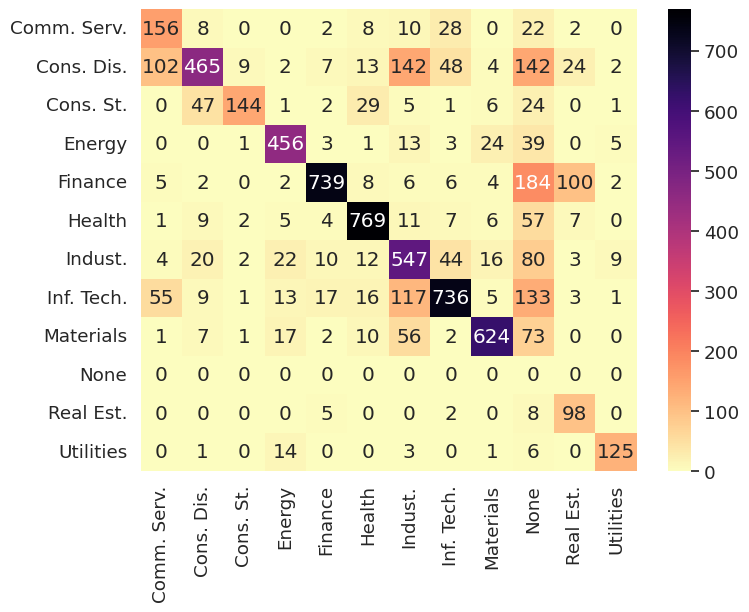